In [ ]:
# Adjoint SWE Solver (v30‑12)

%reload_ext autoreload 
# enables automatic reloading of modules before executing code
%autoreload 2 
# set to reload all modules (except those excluded by %aimport) every time before executing the Python code typed
import sys
print("System path:", sys.executable)
print("Python version:", sys.version)


# --- Python core packages ---
import numpy as np
import matplotlib.pyplot as plt

# --- FEniCS core ---
import dolfin as dlf
from dolfin import (
    Constant, Function, FunctionSpace, VectorFunctionSpace, 
    TestFunctions, TrialFunctions, Expression, interpolate, assign
)

# --- dolfin-adjoint (import early so wrappers are active before constants/functions are created) ---
from dolfin_adjoint import *

# --- UFL symbolic tools ---
import ufl
from ufl import dot, div, grad, nabla_grad, sqrt, inner, derivative, Measure

# --- PETSc bindings for parallel linear algebra ---
from petsc4py import PETSc

# --- project-specific mesh/BC setup ---
from Adjoint_optimisation.set_up_mesh import *       # defines `mesh`
from Adjoint_optimisation.set_up_bcs import *        # defines `bcs`
from Adjoint_optimisation.place_turbines_random import *   #defintes "initial placement"

print("✅ Thesis adjoint SWE solver ready (v30-12)")

System path: /home/zabreedveld/miniconda3/envs/fenicsproject/bin/python
Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
✅ Thesis adjoint SWE solver ready (v28-12)


Parameters:

In [218]:
# Step 2 — Base physical & numerical parameters
# Define constants and parameters for the SWE model
# --- Physical constants ---
rho  = Constant(1025.0)     # density [kg/m³]
g    = Constant(9.81)       # gravity [m/s²]
nu   = Constant(1.0)        # eddy viscosity [m²/s]
h0   = Constant(40.0)       # mean depth [m]
# --- Turbine and drag coefficients ---
C_T = 0.7                   # thrust coefficient
C_D = 0.0025                # background drag coefficient
D = 5.0                     # turbine diameter [m]
sigma = 0.5*D               # gaussian width [m]
A_T = np.pi * D**2          # turbine swept area [m²]

# --- Flow and boundary data ---
U_inflow = 2.0              # deth-averaged inflow velocity [m/s]
initial_condition_u = Constant((2.0, 0.0))  # initial velocity field
initial_condition_eta = Constant(0.0)       # initial free surface elevation

# --- Domain size and mesh resolution ---
Lx, Ly = 800.0, 1400.0    # domain dimensions [m]
Nx, Ny = 50, 40          # mesh resolution

# --- Turbine layout parameters ---
n_turbines = 21 # number of turbines
min_spacing = 2 * D # minimum spacing between turbines [m]

xn = 3  # number of turbines in x-direction
yn = n_turbines/xn # number of turbines in y-direction

# --- Plot toggles ---
show_mesh_plot = False # toggle to plot the mesh
show_plot_turbines = True # toggle to show turbine layout plot
show_turbines_coordinates = True # toggle to show turbine coordinates


print(f"Base parameters initialized successfully, Zoë.")


Base parameters initialized successfully, Zoë.


Building mesh, inserting boundary conditions and initial placement of turbines

Mesh and mixed space initialised.
Boundary markers created and BCs applied:
   - Inlet  (ID=1): inflow velocity = 2.00 m/s
   - Outlet (ID=2): open boundary (no Dirichlet BC)
   - Walls  (ID=3): free‑slip (no Dirichlet BC)

Managed to place  21  turbines within  21  attempts.
Turbines placed successfully.
Turbine coordinates display not requested.


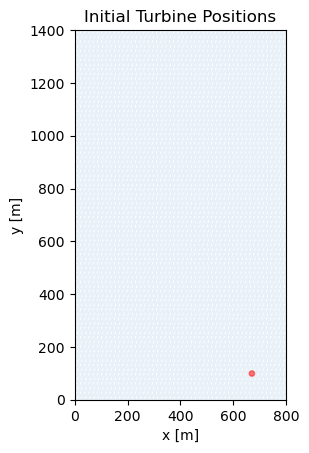

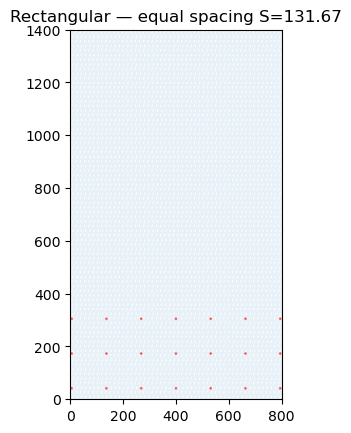

In [217]:
mesh, W, w, u, eta, v, q = mesh_set_up(Lx, Ly, Nx, Ny, show_mesh_plot)
boundary_markers, bcs = setup_boundary_markers_and_bcs(mesh, W, Lx, Ly, U_inflow)
initial_positions_random = place_turbines_random2(mesh, Lx, Ly, n_turbines, min_spacing, D)
initial_positions_rectangular = place_turbines_rectangular_equal_spacing(mesh, Lx, Ly, n_turbines, min_spacing, D, show_plot_turbines, nx=xn, ny=yn)


In [73]:
import dolfin_adjoint as adj
from ufl import derivative

# 1️⃣ use a Dolfin Jacobian with a mixed TrialFunction so shape matches w
J_F = dlf.derivative(F, w, dlf.TrialFunction(W))   # proper dolfin Form

# 2️⃣ ensure annotation is active
try:
    adj.continue_annotation()
except Exception:
    pass

# 3️⃣ build and solve (standard solver)
print('tape blocks before solve:', len(adj.get_working_tape()._blocks))
problem = dlf.NonlinearVariationalProblem(F, w, bcs, J=J_F)
solver  = dlf.NonlinearVariationalSolver(problem)

solver.parameters["newton_solver"]["linear_solver"] = "mumps"
solver.parameters["newton_solver"]["absolute_tolerance"] = 1e-8
solver.parameters["newton_solver"]["relative_tolerance"] = 1e-7

# Print BC diagnostics
print('BCs:', [(type(bc), hasattr(bc, 'block_variable'), hasattr(bc, '_ad_will_add_as_dependency')) for bc in bcs])

solver.solve()
print('✅ Forward SWE solve complete.')
print('tape blocks after solve:', len(adj.get_working_tape()._blocks))

# -------------------
# Objective Functional (assemble *after* solve)
# -------------------
# wrap the solved state into a dolfin-adjoint Function so it provides required methods
try:
    w_wrapped = adj.Function(w)  # wrap existing Function if possible
except Exception:
    w_wrapped = adj.Function(W, name='w')
    dlf.assign(w_wrapped, w)

# Use the wrapped state's velocity component for J_form
u, eta_wrapped = dlf.split(w_wrapped)
# ensure dx uses the current mesh
new_dx = ufl.Measure("dx", domain=mesh)
J_form = 0.5 * inner(u, u) * new_dx

# assemble with adj so the operation is recorded on the tape
J = adj.assemble(J_form)

# -------------------
# Adjoint / gradient
# -------------------
m = adj.Control(cb)
rf = adj.ReducedFunctional(J, m)

print('Computing gradient (this will evaluate the adjoint)')
grad = rf.derivative()
print('Adjoint gradient computed.')

tape blocks before solve: 4
BCs: [(<class 'dolfin.fem.dirichletbc.DirichletBC'>, False, False)]
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.411e-09 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
✅ Forward SWE solve complete.
tape blocks after solve: 4
Computing gradient (this will evaluate the adjoint)


AttributeError: 'float' object has no attribute '_cpp_object'

In [67]:
print("F type:", type(F))
print("unknown type:", type(w))

print(type(w))
print(type(v))
print(type(F))

print(type(V_ctrl))
print(type(cb))

print("cb type:", type(cb))
print("F type:", type(F))
print("grad type:", type(grad))

print("mesh type:", type(mesh))
print(mesh)

print("w:", type(w))
print("u:", type(u))
print("eta:", type(eta))
print("v:", type(v))

(v, q) = TestFunctions(W)
print("v:", type(v))


F type: <class 'ufl.form.Form'>
unknown type: <class 'dolfin.function.function.Function'>
<class 'dolfin.function.function.Function'>
<class 'ufl.tensors.ListTensor'>
<class 'ufl.form.Form'>
<class 'dolfin.function.functionspace.FunctionSpace'>
<class 'fenics_adjoint.types.function.Function'>
cb type: <class 'fenics_adjoint.types.function.Function'>
F type: <class 'ufl.form.Form'>
grad type: <class 'function'>
mesh type: <class 'module'>
<module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>
w: <class 'dolfin.function.function.Function'>
u: <class 'ufl.tensors.ListTensor'>
eta: <class 'ufl.indexed.Indexed'>
v: <class 'ufl.tensors.ListTensor'>
v: <class 'ufl.tensors.ListTensor'>
